In [1]:
#import codecarbon

In [2]:
#tracker = EmissionsTracker()
#tracker.start()
# GPU Intensive code goes here
#tracker.stop()

In [3]:
import tensorflow
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.datasets import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense, Flatten,Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import itertools
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.utils import class_weight
import tensorflow_addons as tfa
import pathlib
from tensorflow.keras import regularizers
#model = tensorflow.keras.models.load_model("../input/models/inception_val69167.h5")
#os.mkdir("/kaggle/working/models")
os.chdir("/kaggle/input/knee-osteoarthritis-dataset-with-severity")

In [4]:
base_dir = "/kaggle/input/knee-osteoarthritis-dataset-with-severity"
train_path = os.path.join(base_dir,'train')
valid_path = os.path.join(base_dir,'val')
test_path = os.path.join(base_dir, 'test')

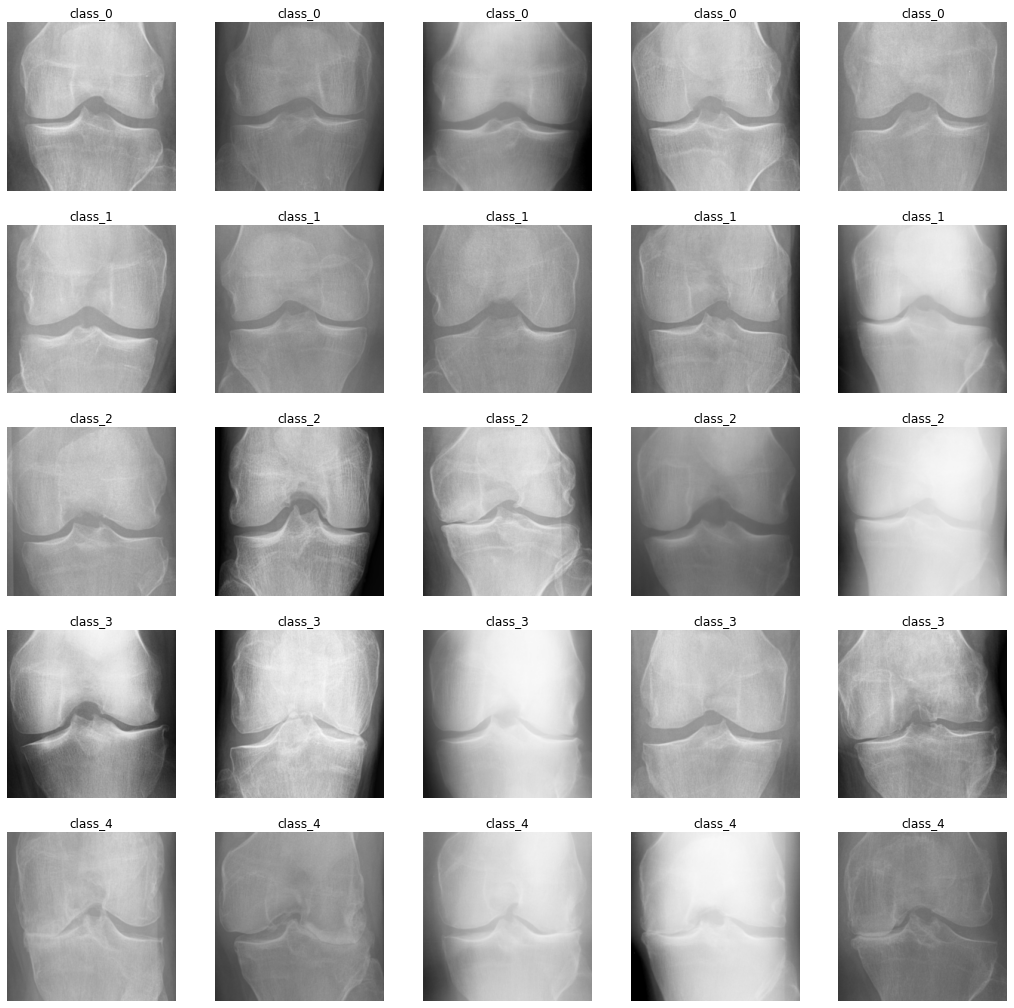

In [5]:
import random
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import cv2

ig, ax = plt.subplots(5,5, figsize=(18,18))

for class_id in range(5):
    folder = os.path.join(train_path,str(class_id))
    os.chdir(folder)
    samples = random.sample(os.listdir(folder), 5)
    
    for col in range(5):
        image = cv2.imread(samples[col])
        ax[class_id, col].imshow(image)
        ax[class_id, col].set_title("class_" + str(class_id))
        ax[class_id, col].set_axis_off()
    
plt.show()

In [6]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.4):
    h = tensorflow.shape(img)[0]
    w = tensorflow.shape(img)[1]
    c = tensorflow.shape(img)[2]
    origin_area = tensorflow.cast(h*w, tensorflow.float32)

    e_size_l = tensorflow.cast(tensorflow.round(tensorflow.sqrt(origin_area * sl * rl)), tensorflow.int32)
    e_size_h = tensorflow.cast(tensorflow.round(tensorflow.sqrt(origin_area * sh / rl)), tensorflow.int32)

    e_height_h = tensorflow.minimum(e_size_h, h)
    e_width_h = tensorflow.minimum(e_size_h, w)

    erase_height = tensorflow.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tensorflow.int32)
    erase_width = tensorflow.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tensorflow.int32)

    erase_area = tensorflow.zeros(shape=[erase_height, erase_width, c])
    erase_area = tensorflow.cast(erase_area, tensorflow.uint8)

    pad_h = h - erase_height
    pad_top = tensorflow.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tensorflow.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tensorflow.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tensorflow.int32)
    pad_right = pad_w - pad_left

    erase_mask = tensorflow.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tensorflow.squeeze(erase_mask, axis=0)
    erased_img = tensorflow.multiply(tensorflow.cast(img,tensorflow.float32), tensorflow.cast(erase_mask, tensorflow.float32))

    return tensorflow.cond(tensorflow.random.uniform([], 0, 1) > p, lambda: tensorflow.cast(img, img.dtype), lambda:  tensorflow.cast(erased_img, img.dtype))

In [7]:
# Use GPU
sess = tensorflow.compat.v1.Session(config=tensorflow.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [8]:
base = tensorflow.keras.applications.DenseNet201(
        include_top=False,
        input_tensor=None,
        input_shape=None)
base.summary()

74842112/74836368 [==============================] - 2s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_______________________

In [9]:
'''
lr = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=9,
    verbose=2,
    mode="max",
    min_delta=0.0001,
    min_lr=0.000001
)
'''

'\nlr = tensorflow.keras.callbacks.ReduceLROnPlateau(\n    monitor="val_loss",\n    factor=0.1,\n    patience=9,\n    verbose=2,\n    mode="max",\n    min_delta=0.0001,\n    min_lr=0.000001\n)\n'

In [10]:
    x = base.output
    x= keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.4)(x)
    predictions =Dense(units=5, activation = 'softmax', kernel_regularizer=regularizers.l1_l2(l1=0.02, l2=0.02))(x)
    model = Model(inputs=base.input, outputs=predictions)
    model.compile(Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [11]:
batch=32
train_batches= ImageDataGenerator(horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.3,rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.15,
    zoom_range=0.2,
    preprocessing_function = random_erasing).flow_from_directory(train_path, target_size=(224,224), classes=['0','1','2','3','4'], batch_size=batch)
valid_batches= ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['0','1','2','3','4'], batch_size=batch)
test_batches= ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['0','1','2','3','4'], batch_size=batch, shuffle= False)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


In [12]:
'''
 class_weights = class_weight.compute_class_weight(
            'balanced',
             np.unique(train_batches.classes), 
             train_batches.classes)

 train_weights = dict(enumerate(class_weights))
 train_weights
 '''

"\n class_weights = class_weight.compute_class_weight(\n            'balanced',\n             np.unique(train_batches.classes), \n             train_batches.classes)\n\n train_weights = dict(enumerate(class_weights))\n train_weights\n "

In [13]:
checkpoint = ModelCheckpoint(filepath='/kaggle/working/Best_DenseNet201.h5',verbose=2, save_best_only=True, monitor = 'val_accuracy')

e = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=20, verbose=2, restore_best_weights=True)

callbacks = [checkpoint, e]

start = datetime.now()

In [14]:
history = model.fit(train_batches, steps_per_epoch=5778//batch, validation_data=valid_batches, validation_steps=826//batch, epochs=120, verbose=2, callbacks = callbacks)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/120
180/180 - 193s - loss: 7.2451 - accuracy: 0.2598 - val_loss: 6.8422 - val_accuracy: 0.3913

Epoch 00001: val_accuracy improved from -inf to 0.39125, saving model to /kaggle/working/Best_DenseNet201.h5
Epoch 2/120
180/180 - 152s - loss: 6.7932 - accuracy: 0.3557 - val_loss: 6.4704 - val_accuracy: 0.4613

Epoch 00002: val_accuracy improved from 0.39125 to 0.46125, saving model to /kaggle/working/Best_DenseNet201.h5
Epoch 3/120
180/180 - 151s - loss: 6.4559 - accuracy: 0.4022 - val_loss: 6.1638 - val_accuracy: 0.4762

Epoch 00003: val_accuracy improved from 0.46125 to 0.47625, saving model to /kaggle/working/Best_DenseNet201.h5
Epoch 4/120
180/180 - 151s - loss: 6.1680 - accuracy: 0.4220 - val_loss: 5.9318 - val_accuracy: 0.4600

Epoch 00004: val_accuracy did not improve from 0.47625
Epoch 5/120
180/180 - 151s - loss: 5.9261 - accuracy: 0.4250 - val_loss: 5.6583 - val_accuracy: 0.4900

Epoch 00005: val_accuracy improved from 0.47625 to 0.49000, saving model to /kaggle/working/

In [15]:
model.save('/kaggle/working/densenet.h5')
#model = keras.models.load_model('/kaggle/working/Best_DenseNet201.h5')

In [16]:
model.evaluate(test_batches)

52/52 [==============================] - 13s 243ms/step - loss: 1.2874 - accuracy: 0.6824


[1.2873945236206055, 0.6823671460151672]

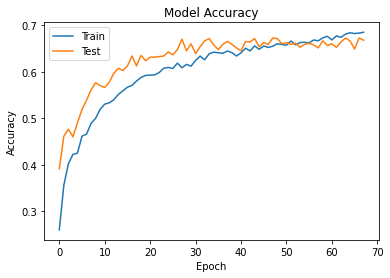

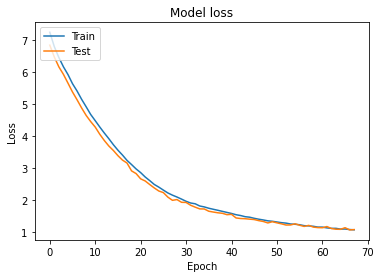

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
# Confusion Matrix and Classification Report
Y_pred = model.predict_generator(test_batches, 1656 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_batches.classes, y_pred))
print('Classification Report')
target_names = ['0','1','2','3','4']
print(classification_report(test_batches.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[601  17  20   1   0]
 [192  39  63   2   0]
 [ 97  46 294  10   0]
 [  3   9  48 158   5]
 [  0   0   0  13  38]]
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.94      0.78       639
           1       0.35      0.13      0.19       296
           2       0.69      0.66      0.67       447
           3       0.86      0.71      0.78       223
           4       0.88      0.75      0.81        51

    accuracy                           0.68      1656
   macro avg       0.69      0.64      0.65      1656
weighted avg       0.65      0.68      0.65      1656

